<a href="https://colab.research.google.com/github/samiksha261/Tensorflow-File/blob/main/16_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

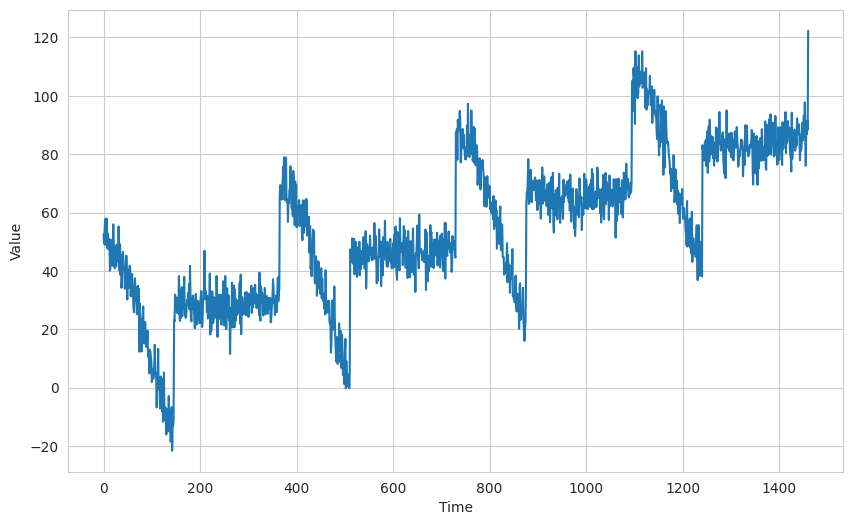

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import tensorflow as tf
keras = tf.keras


def plot_series(time,series,format="-",start=0,end=None,label=None):
    plt.plot(time[start:end], series[start:end],format,label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

    
def trend(time,slope=0):
    return slope*time
    
#seasonal Data
def seasonal_pattern(season_time):
    return np.where(season_time< 0.4,np.cos(season_time*2*np.pi),
                   1/np.exp(3*season_time))

def seasonality(time,period,amplitude=1,phase=0):
    season_time = ((time+phase)%period)/period
    return amplitude*seasonal_pattern(season_time)

# noise
def white_noise(time,noise_level=1,seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


time = np.arange(4*365+1)
slope = 0.05
baseline = 10
amplitude = 40



series = baseline+trend(time,slope)+seasonality(time,period=365,amplitude=amplitude)
noise_level = 5
noise = white_noise(time,noise_level,seed=42)
series += noise




plt.figure(figsize=(10,6))
plot_series(time,series)
plt.show()

In [2]:
def sequential_window_dataset(series,window_size):
    series = tf.expand_dims(series,axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1,shift=window_size,drop_remainder=True)
    ds = ds.flat_map(lambda window:window.batch(window_size+1))
    ds = ds.map(lambda window:(window[:-1],window[1:]))
    return ds.batch(1).prefetch(1)

In [3]:
split_time = 1000
time_train = time[:split_time]
X_train = series[:split_time]
time_valid = time[split_time:]
X_valid = series[split_time:]

In [4]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 30

In [5]:
train_set = sequential_window_dataset(X_train,window_size)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [6]:
model = keras.models.Sequential([
    keras.layers.LSTM(100,return_sequences=True,stateful=True,batch_input_shape=[1,None,1]),
    keras.layers.LSTM(100,return_sequences=True,stateful=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x*200.0)
])


In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, None, 100)            40800     
                                                                 
 lstm_1 (LSTM)               (1, None, 100)            80400     
                                                                 
 dense (Dense)               (1, None, 1)              101       
                                                                 
 lambda (Lambda)             (1, None, 1)              0         
                                                                 
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [8]:
lr_schedule = keras.callbacks.LearningRateScheduler(
lambda epoch: 1e-8*10**(epoch/20))

In [9]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self,epoch,logs):
        self.model.reset_states()

In [10]:
reset_states = ResetStatesCallback()

In [11]:
optimizer = keras.optimizers.SGD(learning_rate=1e-8,momentum=0.9)
model.compile(loss=keras.losses.Huber(),optimizer=optimizer,metrics=['mae'])

In [12]:
history = model.fit(train_set,epochs=100,callbacks=[lr_schedule,reset_states])

Epoch 1/100
33/33 [==============================] - 8s 37ms/step - loss: 51.6142 - mae: 52.1126 - lr: 1.0000e-08
Epoch 2/100
33/33 [==============================] - 1s 19ms/step - loss: 47.0316 - mae: 47.5291 - lr: 1.1220e-08
Epoch 3/100
33/33 [==============================] - 1s 17ms/step - loss: 41.8877 - mae: 42.3862 - lr: 1.2589e-08
Epoch 4/100
33/33 [==============================] - 1s 17ms/step - loss: 36.6769 - mae: 37.1740 - lr: 1.4125e-08
Epoch 5/100
33/33 [==============================] - 1s 17ms/step - loss: 32.2993 - mae: 32.7952 - lr: 1.5849e-08
Epoch 6/100
33/33 [==============================] - 1s 18ms/step - loss: 29.1149 - mae: 29.6109 - lr: 1.7783e-08
Epoch 7/100
33/33 [==============================] - 1s 17ms/step - loss: 26.6352 - mae: 27.1334 - lr: 1.9953e-08
Epoch 8/100
33/33 [==============================] - 1s 19ms/step - loss: 24.4171 - mae: 24.9150 - lr: 2.2387e-08
Epoch 9/100
33/33 [==============================] - 1s 29ms/step - loss: 21.8652 - mae:

(1e-08, 0.0001, 0.0, 30.0)

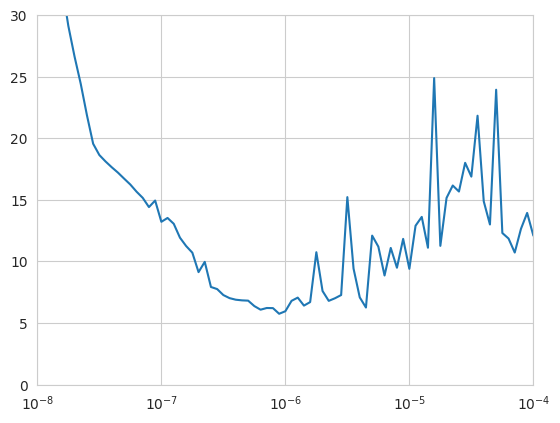

In [13]:
plt.semilogx(history.history['lr'],history.history['loss'])
plt.axis([1e-8,1e-4,0,30])


In [14]:

# Second
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [15]:
window_size = 30
train_set = sequential_window_dataset(X_train,window_size)
valid_set = sequential_window_dataset(X_valid,window_size)

In [16]:
model = keras.models.Sequential([
    keras.layers.LSTM(100,return_sequences=True,stateful=True,batch_input_shape=[1,None,1]),
    keras.layers.LSTM(100,return_sequences=True,stateful=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x*200.0)
])

In [17]:
optimizer = keras.optimizers.SGD(learning_rate=1e-5,momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

In [18]:
reset_states = ResetStatesCallback()

In [19]:
model_checkpoint = keras.callbacks.ModelCheckpoint("my_checkpoint.h5",save_best_only=True)

In [20]:
early_stopping = keras.callbacks.EarlyStopping(patience=50)

In [21]:
model.fit(train_set,epochs=500,
         validation_data=valid_set,callbacks=[early_stopping,model_checkpoint,reset_states])

Epoch 1/500
33/33 [==============================] - 5s 52ms/step - loss: 22.2533 - mae: 22.7491 - val_loss: 8.7515 - val_mae: 9.2410
Epoch 2/500
33/33 [==============================] - 1s 21ms/step - loss: 21.4396 - mae: 21.9331 - val_loss: 11.5107 - val_mae: 11.9976
Epoch 3/500
33/33 [==============================] - 1s 20ms/step - loss: 18.2387 - mae: 18.7333 - val_loss: 41.9903 - val_mae: 42.4903
Epoch 4/500
33/33 [==============================] - 1s 21ms/step - loss: 16.6351 - mae: 17.1302 - val_loss: 9.2591 - val_mae: 9.7498
Epoch 5/500
33/33 [==============================] - 1s 21ms/step - loss: 12.4000 - mae: 12.8921 - val_loss: 37.2224 - val_mae: 37.7224
Epoch 6/500
33/33 [==============================] - 2s 49ms/step - loss: 12.0882 - mae: 12.5800 - val_loss: 19.2463 - val_mae: 19.7452
Epoch 7/500
33/33 [==============================] - 1s 21ms/step - loss: 7.1942 - mae: 7.6817 - val_loss: 6.8260 - val_mae: 7.3121
Epoch 8/500
33/33 [==============================] - 1s 

In [22]:

model = keras.models.load_model("my_checkpoint.h5")

In [23]:
rnn_forecast = model.predict(series[np.newaxis, : ,np.newaxis])

1/1 [==============================] - 2s 2s/step


In [24]:
rnn_forecast = rnn_forecast[0,split_time-1:-1,0]

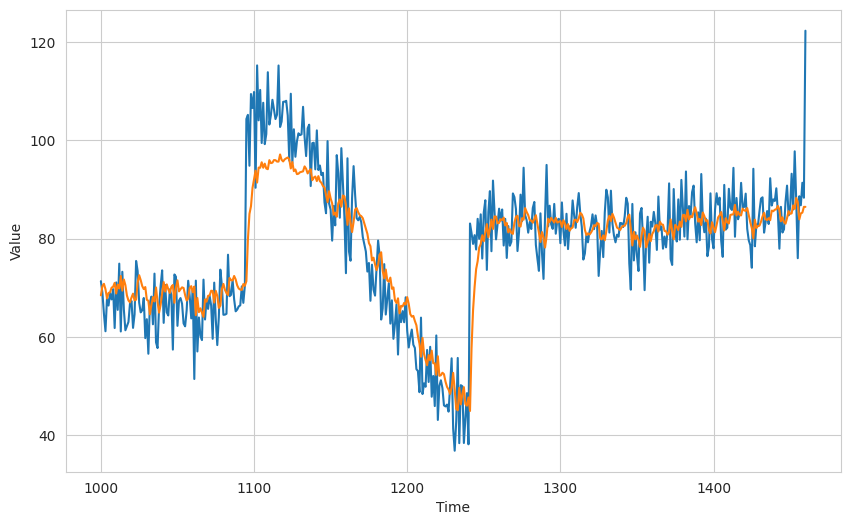

In [25]:
plt.figure(figsize=(10,6))
plot_series(time_valid,X_valid)
plot_series(time_valid,rnn_forecast)

Forecasting With CNN

In [26]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 30


def seq2_seq_window_dataset(series,window_size,batch_size=32,shuffle_buffer=1000):
    series = tf.expand_dims(series,axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1,shift=1,drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size+1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1],w[1:]))
    return ds.batch(batch_size).prefetch(1)


train_set = seq2_seq_window_dataset(X_train,window_size,batch_size=128)

In [27]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=32,kernel_size=5,strides=1,padding='causal',activation='relu',input_shape=[None,1]),
    keras.layers.LSTM(32,return_sequences=True),
    keras.layers.LSTM(32,return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x*200),
])

In [28]:
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8*10**(epoch/20))

In [29]:
optimizer = keras.optimizers.SGD(learning_rate=1e-8,momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

In [30]:
history = model.fit(train_set,epochs=100,callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 5s 40ms/step - loss: 34.1510 - mae: 34.6480 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 0s 40ms/step - loss: 33.6225 - mae: 34.1195 - lr: 1.1220e-08
Epoch 3/100
8/8 [==============================] - 0s 40ms/step - loss: 32.7165 - mae: 33.2134 - lr: 1.2589e-08
Epoch 4/100
8/8 [==============================] - 0s 38ms/step - loss: 31.3873 - mae: 31.8847 - lr: 1.4125e-08
Epoch 5/100
8/8 [==============================] - 0s 38ms/step - loss: 28.7084 - mae: 29.2054 - lr: 1.5849e-08
Epoch 6/100
8/8 [==============================] - 0s 39ms/step - loss: 24.3219 - mae: 24.8172 - lr: 1.7783e-08
Epoch 7/100
8/8 [==============================] - 0s 44ms/step - loss: 22.5311 - mae: 23.0264 - lr: 1.9953e-08
Epoch 8/100
8/8 [==============================] - 1s 51ms/step - loss: 22.1423 - mae: 22.6379 - lr: 2.2387e-08
Epoch 9/100
8/8 [==============================] - 1s 67ms/step - loss: 21.9285 - mae: 22.4242 - lr: 2.5

(1e-08, 0.0001, 0.0, 30.0)

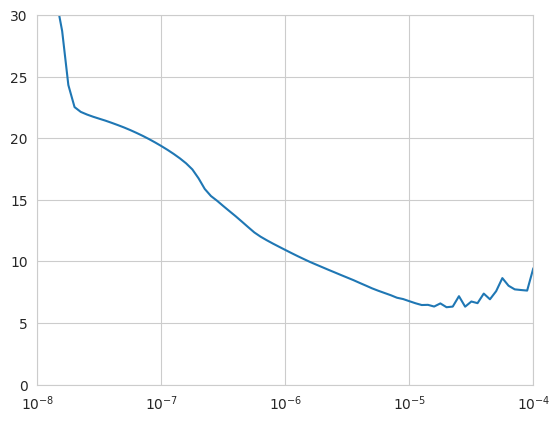

In [31]:
plt.semilogx(history.history['lr'],history.history['loss'])
plt.axis([1e-8,1e-4,0,30])

In [32]:
# Second
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 30

In [33]:
window_size = 30

In [34]:
train_set = seq2_seq_window_dataset(X_train,window_size,batch_size=128)
valid_set = seq2_seq_window_dataset(X_valid,window_size,batch_size=128)

In [35]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=32,kernel_size=5,strides=1,padding='causal',activation='relu',input_shape=[None,1]),
    keras.layers.LSTM(32,return_sequences=True),
    keras.layers.LSTM(32,return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x*200),
])

In [36]:
optimizer = keras.optimizers.SGD(learning_rate=1e-5,momentum=0.9)
model.compile(loss=keras.losses.Huber(),optimizer=optimizer,
             metrics=['mae'])

In [37]:
model_checkpoint = keras.callbacks.ModelCheckpoint("my_checkpoint.h5",save_best_only=True)

In [38]:
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set,epochs=500,validation_data=valid_set,
         callbacks=[early_stopping,model_checkpoint])

Epoch 1/500
8/8 [==============================] - 5s 195ms/step - loss: 20.6396 - mae: 21.1351 - val_loss: 21.4226 - val_mae: 21.9181
Epoch 2/500
8/8 [==============================] - 1s 94ms/step - loss: 12.1505 - mae: 12.6413 - val_loss: 23.0273 - val_mae: 23.5250
Epoch 3/500
8/8 [==============================] - 1s 63ms/step - loss: 8.9225 - mae: 9.4077 - val_loss: 15.5681 - val_mae: 16.0624
Epoch 4/500
8/8 [==============================] - 1s 60ms/step - loss: 7.7865 - mae: 8.2691 - val_loss: 11.8925 - val_mae: 12.3819
Epoch 5/500
8/8 [==============================] - 1s 56ms/step - loss: 7.3080 - mae: 7.7902 - val_loss: 12.3421 - val_mae: 12.8326
Epoch 6/500
8/8 [==============================] - 1s 59ms/step - loss: 7.1098 - mae: 7.5923 - val_loss: 10.9943 - val_mae: 11.4831
Epoch 7/500
8/8 [==============================] - 1s 59ms/step - loss: 6.9416 - mae: 7.4231 - val_loss: 11.4541 - val_mae: 11.9434
Epoch 8/500
8/8 [==============================] - 1s 61ms/step - loss:

In [39]:
def model_forcast(model,series,window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size,shift=1,drop_remainder=True)
    ds = ds.flat_map(lambda w:w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [40]:
model = keras.models.load_model("my_checkpoint.h5")

In [41]:
rnn_forecast = model_forcast(model,series[:,np.newaxis],window_size)

45/45 [==============================] - 2s 15ms/step


In [42]:
rnn_forecast = rnn_forecast[split_time-window_size:-1,-1,0]


In [43]:
rnn_forecast

array([64.24622 , 66.65584 , 67.52792 , 66.40564 , 65.85654 , 66.94276 ,
       67.179214, 67.28362 , 66.595184, 67.52801 , 66.71383 , 67.81078 ,
       67.72165 , 69.36958 , 67.42533 , 69.04637 , 68.488396, 67.77571 ,
       65.89123 , 66.1971  , 66.213104, 65.78757 , 64.79752 , 64.59623 ,
       66.584045, 68.48717 , 67.849884, 67.12837 , 68.20288 , 68.732   ,
       67.168655, 66.23582 , 64.809975, 65.34136 , 64.99134 , 64.658775,
       65.140724, 64.91006 , 63.85193 , 63.917595, 65.46499 , 66.62454 ,
       65.03434 , 66.32095 , 67.19023 , 67.347015, 67.07301 , 67.85562 ,
       65.7103  , 66.50471 , 67.78753 , 66.88463 , 65.199425, 66.77409 ,
       67.292336, 65.884056, 65.50617 , 65.77717 , 66.779274, 66.763405,
       65.774414, 66.435555, 64.83573 , 66.28257 , 64.839066, 65.23322 ,
       62.326588, 62.942303, 63.833652, 64.34156 , 64.72709 , 64.267075,
       66.20555 , 66.18507 , 65.45757 , 66.41504 , 66.50551 , 64.9101  ,
       63.842327, 66.030655, 67.287025, 65.93392 , 

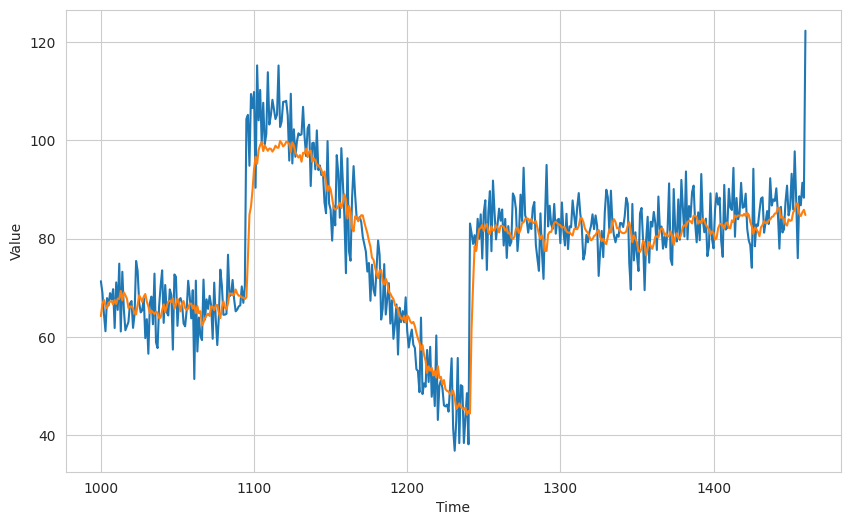

In [44]:
plt.figure(figsize=(10,6))
plot_series(time_valid,X_valid)
plot_series(time_valid,rnn_forecast)

Fully Convolutional Forcasting

In [45]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 64


In [46]:
train_set = seq2_seq_window_dataset(X_train,window_size,batch_size=128)

In [47]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None,1]))
for dilation_rate in (1,2,4,8,16,32):
    model.add(
        keras.layers.Conv1D(filters=32,kernel_size=2,strides=1,dilation_rate=dilation_rate,padding='causal',activation='relu')
    )
model.add(keras.layers.Conv1D(filters=1,kernel_size=1))

In [48]:

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 32)          96        
                                                                 
 conv1d_1 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_2 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_3 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_4 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_5 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_6 (Conv1D)           (None, None, 1)           3

In [49]:
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4*10**(epoch/30))

In [50]:
optimizer = keras.optimizers.Adam(learning_rate=1e-4)

In [51]:
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

In [52]:
history = model.fit(train_set,epochs=100,callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 3s 61ms/step - loss: 41.4375 - mae: 41.9368 - lr: 1.0000e-04
Epoch 2/100
8/8 [==============================] - 1s 81ms/step - loss: 41.1455 - mae: 41.6447 - lr: 1.0798e-04
Epoch 3/100
8/8 [==============================] - 1s 89ms/step - loss: 40.7603 - mae: 41.2595 - lr: 1.1659e-04
Epoch 4/100
8/8 [==============================] - 1s 52ms/step - loss: 40.2355 - mae: 40.7348 - lr: 1.2589e-04
Epoch 5/100
8/8 [==============================] - 1s 53ms/step - loss: 39.5157 - mae: 40.0149 - lr: 1.3594e-04
Epoch 6/100
8/8 [==============================] - 1s 53ms/step - loss: 38.4865 - mae: 38.9854 - lr: 1.4678e-04
Epoch 7/100
8/8 [==============================] - 1s 51ms/step - loss: 36.8990 - mae: 37.3974 - lr: 1.5849e-04
Epoch 8/100
8/8 [==============================] - 1s 51ms/step - loss: 34.4946 - mae: 34.9933 - lr: 1.7113e-04
Epoch 9/100
8/8 [==============================] - 1s 55ms/step - loss: 30.6692 - mae: 31.1672 - lr: 1.8

(0.0001, 0.1, 0.0, 30.0)

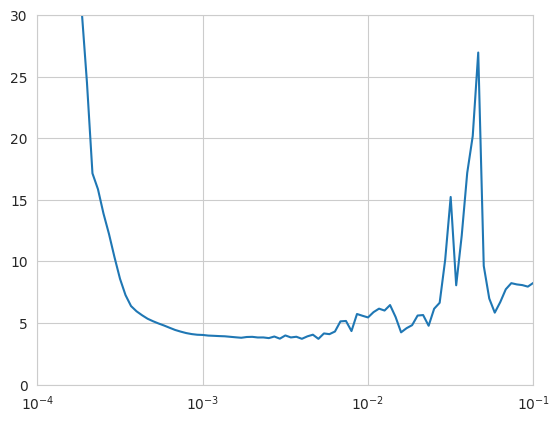

In [53]:
plt.semilogx(history.history['lr'],history.history['loss'])
plt.axis([1e-4,1e-1,0,30])

In [54]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 64

In [55]:
train_set = seq2_seq_window_dataset(X_train,window_size,batch_size=128)
valid_set = seq2_seq_window_dataset(X_valid,window_size,batch_size=128)

In [56]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None,1]))
for dilation_rate in (1,2,4,8,16,32):
    model.add(
        keras.layers.Conv1D(filters=32,kernel_size=2,strides=1,dilation_rate=dilation_rate,padding='causal',activation='relu')
    )
model.add(keras.layers.Conv1D(filters=1,kernel_size=1))

In [57]:
optimizer = keras.optimizers.Adam(learning_rate=3e-4)

In [58]:
model.compile(loss=keras.callbacks.EarlyStopping(patience=50))
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

model_checkpoint = keras.callbacks.ModelCheckpoint("my_checkpoint.h5",save_best_only=True)
history = model.fit(train_set,epochs=500,validation_data=valid_set,
                   callbacks=[early_stopping,model_checkpoint])

Epoch 1/500
8/8 [==============================] - 4s 156ms/step - loss: 39.2529 - mae: 39.7521 - val_loss: 71.1859 - val_mae: 71.6859
Epoch 2/500
8/8 [==============================] - 1s 80ms/step - loss: 37.2176 - mae: 37.7164 - val_loss: 66.3654 - val_mae: 66.8654
Epoch 3/500
8/8 [==============================] - 1s 106ms/step - loss: 34.0856 - mae: 34.5837 - val_loss: 58.5533 - val_mae: 59.0533
Epoch 4/500
8/8 [==============================] - 1s 150ms/step - loss: 28.9902 - mae: 29.4884 - val_loss: 45.7112 - val_mae: 46.2112
Epoch 5/500
8/8 [==============================] - 1s 76ms/step - loss: 20.9251 - mae: 21.4218 - val_loss: 25.4879 - val_mae: 25.9847
Epoch 6/500
8/8 [==============================] - 1s 75ms/step - loss: 13.5448 - mae: 14.0351 - val_loss: 21.9144 - val_mae: 22.4106
Epoch 7/500
8/8 [==============================] - 1s 75ms/step - loss: 13.3636 - mae: 13.8564 - val_loss: 17.0831 - val_mae: 17.5743
Epoch 8/500
8/8 [==============================] - 1s 70ms/

In [59]:
cnn_forecast = model_forcast(model,series[...,np.newaxis],window_size)

44/44 [==============================] - 41s 11ms/step


In [60]:
cnn_forecast = cnn_forecast[split_time-window_size:-1,-1,0]

TypeError: ignored

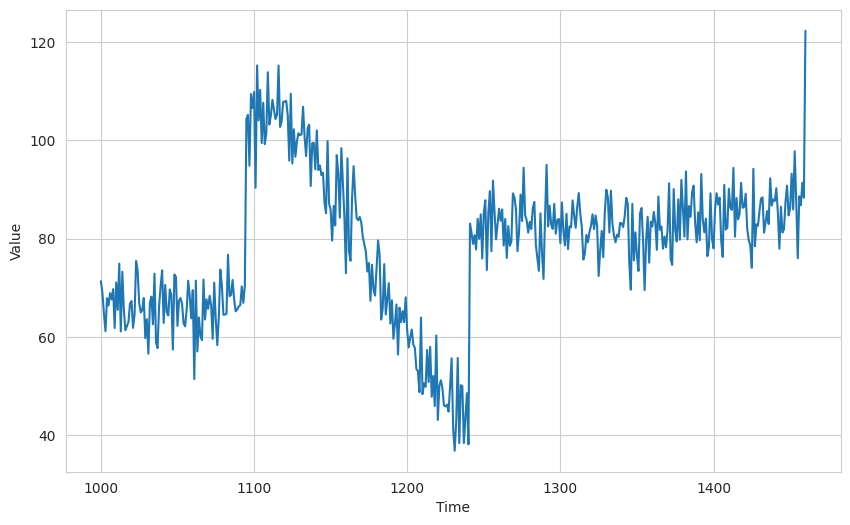

In [61]:
plt.figure(figsize=(10,6))
plot_series(time_valid,X_valid)
plot_series()